In [1]:
import numpy as np
import pandas as pd
#import sklearn
#import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
#import sweetviz as sv
import HelperFunctions as hf
import os 
import tarfile
import zipfile


# Overview

[M5 forecasting challenge](https://www.kaggle.com/c/m5-forecasting-accuracy/data)


## Data Description

- `calendar.csv` - Contains information about the dates on which the products are sold.

- `sales_train_validation.csv` - Contains the historical daily unit sales data per product and store `[d_1 - d_1913]`

- `sell_prices.csv` - Contains information about the price of the products sold per store and date.

- `sample_submission.csv` - The correct format for submissions. Reference the [Evaluation](https://www.kaggle.com/c/m5-forecasting-accuracy/overview/evaluation) tab for more info.

- `sales_train_evaluation.csv` - Includes sales `[d_1 - d_1941]` (labels used for the Public leaderboard)


## Task

- Forecast daily sales for the next 28 days



# READ ME!

To use the data you can either download the data and pre-process it into the right format or use hf to import it directly (quite a bit faster) see section 3

# 1. Download the Data

In [2]:
%%bash

kaggle competitions download m5-forecasting-accuracy -p data


100%|██████████| 45.8M/45.8M [00:08<00:00, 5.78MB/s]


In [3]:
def fetch_walmat_data():
    zip_path = os.path.join('data', 'm5-forecasting-accuracy.zip')    
    
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('data')
    
    print(zip_ref.namelist())

fetch_walmat_data()


['calendar.csv', 'sales_train_evaluation.csv', 'sales_train_validation.csv', 'sample_submission.csv', 'sell_prices.csv']


# 2. Read the Data

In [2]:
def load_calendar_data():    
    csv_path = os.path.join('data', 'calendar.csv')
    return pd.read_csv(csv_path)


def load_sell_price_data():
    csv_path = os.path.join('data', 'sell_prices.csv')
    return pd.read_csv(csv_path)


def load_sales_train_validation_data():
    csv_path = os.path.join('data', 'sales_train_validation.csv')
    return pd.read_csv(csv_path)


def load_sales_train_evaluation_data():
    csv_path = os.path.join('data', 'sales_train_evaluation.csv')
    return pd.read_csv(csv_path)


## 2.1 Read Calendar

In [3]:
calendar = load_calendar_data()
calendar.head()


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [20]:
print(f'shape: {calendar.shape}\n')

calendar.info()

shape: (1969, 14)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
date            1969 non-null object
wm_yr_wk        1969 non-null int64
weekday         1969 non-null object
wday            1969 non-null int64
month           1969 non-null int64
year            1969 non-null int64
d               1969 non-null object
event_name_1    162 non-null object
event_type_1    162 non-null object
event_name_2    5 non-null object
event_type_2    5 non-null object
snap_CA         1969 non-null int64
snap_TX         1969 non-null int64
snap_WI         1969 non-null int64
dtypes: int64(7), object(7)
memory usage: 215.5+ KB


### Sweetviz

In [22]:
# quick eda by sweetViz
calendar_report = sv.analyze(calendar)

# display the report
calendar_report.show_html('Calendar.html')



Report Calendar.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


# Create the melted dataframe for further analysis

In [4]:
#Read data files
price_df = load_sell_price_data()
sales_df = load_sales_train_evaluation_data()

In [5]:
sales_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


In [6]:
#Create the melted dataframe
df = hf.meltM5(sales_df, days = 600, items = 100)

In [7]:
#Join with calendar and price data
df = hf.joinDataSets(df, calendar, price_df, dropPriceNA=True)

Initial inspection of the raw data

In [8]:
df.shape

(16150, 22)

In [9]:
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
3,FOODS_3_365_TX_3_evaluation,FOODS_3_365,FOODS_3,FOODS,TX_3,TX,d_1,1,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,3.48
8,FOODS_3_485_TX_3_evaluation,FOODS_3_485,FOODS_3,FOODS,TX_3,TX,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,3.48
9,HOUSEHOLD_1_243_TX_3_evaluation,HOUSEHOLD_1_243,HOUSEHOLD_1,HOUSEHOLD,TX_3,TX,d_1,4,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,1.97
10,HOBBIES_1_017_WI_1_evaluation,HOBBIES_1_017,HOBBIES_1,HOBBIES,WI_1,WI,d_1,6,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,1.78
14,HOUSEHOLD_1_381_TX_1_evaluation,HOUSEHOLD_1_381,HOUSEHOLD_1,HOUSEHOLD,TX_1,TX,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,4.14


In [10]:
df.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'sold', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'sell_price'],
      dtype='object')

In [11]:
df.describe()

,sold,wm_yr_wk,wday,month,year,snap_CA,snap_TX,snap_WI,sell_price
count,16150.000000,16150.000000,16150.000000,16150.000000,16150.0,16150.000000,16150.000000,16150.000000,16150.000000
mean,1.722229,11123.089226,3.988483,6.652074,2011.0,0.330464,0.332446,0.332508,4.293509
std,3.100260,12.384845,1.995224,2.848911,0.0,0.470395,0.471104,0.471126,3.333385
min,0.000000,11101.000000,1.000000,1.000000,2011.0,0.000000,0.000000,0.000000,0.940000
25%,0.000000,11112.000000,2.000000,4.000000,2011.0,0.000000,0.000000,0.000000,2.320000
50%,0.000000,11124.000000,4.000000,7.000000,2011.0,0.000000,0.000000,0.000000,3.270000
75%,2.000000,11134.000000,6.000000,9.000000,2011.0,1.000000,1.000000,1.000000,4.980000
max,41.000000,11143.000000,7.000000,11.000000,2011.0,1.000000,1.000000,1.000000,17.240000


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 0 to 29999
Data columns (total 22 columns):
id              30000 non-null object
item_id         30000 non-null object
dept_id         30000 non-null object
cat_id          30000 non-null object
store_id        30000 non-null object
state_id        30000 non-null object
d               30000 non-null object
sold            30000 non-null int64
date            30000 non-null object
wm_yr_wk        30000 non-null int64
weekday         30000 non-null object
wday            30000 non-null int64
month           30000 non-null int64
year            30000 non-null int64
event_name_1    2400 non-null object
event_type_1    2400 non-null object
event_name_2    100 non-null object
event_type_2    100 non-null object
snap_CA         30000 non-null int64
snap_TX         30000 non-null int64
snap_WI         30000 non-null int64
sell_price      15876 non-null float64
dtypes: float64(1), int64(8), object(13)
memory usage: 5.3+ MB


In [14]:
#These are likely seasonal products, such as xmas trees, or brussel sprouts
print("Percentage of products that are not on sale: ", df['sell_price'].isna().sum() / len(df['sell_price']) * 100)

Percentage of products that are not on sale:  47.08


In [15]:
#Function for plotting time series over a group in the data
def GroupTimeSeriesPlot(by):
    group = df[[by,'d','sold']].groupby([by,'d'], as_index=False).sum()
    days = np.array(list(range(1, 731)))

    for cat in np.unique(group[by]):
        category = np.array(group[group[by]==cat]['sold'])
        plt.plot(days, category, label=cat)
        plt.legend()

    plt.xlabel('Day')
    plt.ylabel('Items Sold')
    plt.title('Time Series Plot of Items Sold')
    plt.show()

ValueError: x and y must have same first dimension, but have shapes (730,) and (300,)

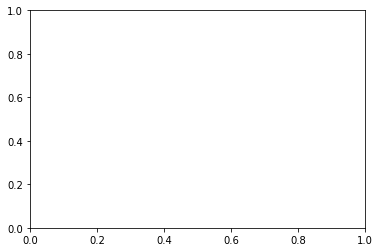

In [16]:
###Finding yearly trends for different product categories
GroupTimeSeriesPlot(by='cat_id')

ValueError: x and y must have same first dimension, but have shapes (730,) and (300,)

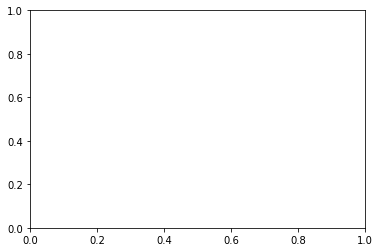

In [17]:
#Time series by state
GroupTimeSeriesPlot(by='state_id')

# 3. Import Pre-Processed Data

Instead of downloading the data then melting and joining you can just import it from the csv with the following function

In [4]:
df_meltedJoined = hf.load_meltedJoined_data()

C:\Users\DIEGO UNZUETA\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (15,16,17,18) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [6]:
df_meltedJoined.shape

(10950000, 23)

This dataset is huge, and so you can use reduceDataset function to reduce it.
Inputs are

- df to reduce
- cuttOffDate (default "2011-06-29")
- numberOfProducts (default 500) - takes 500 random products

In [8]:
df_reduced = hf.reduceDataset(df_meltedJoined)

In [10]:
df_reduced.shape

(74896, 23)

If you're happy with this reduction just import this dataset directly

In [14]:
df = hf.load_reduced_data()

C:\Users\DIEGO UNZUETA\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [15]:
df.shape

(74594, 24)

In [20]:
#Function for plotting time series over a group in the data
def GroupTimeSeriesPlot(by):
    group = df[[by,'d','sold']].groupby([by,'d'], as_index=False).sum()
    days = np.array(list(range(1, 152)))

    for cat in np.unique(group[by]):
        category = np.array(group[group[by]==cat]['sold'])
        plt.plot(days, category, label=cat)
        plt.legend()

    plt.xlabel('Day')
    plt.ylabel('Items Sold')
    plt.title('Time Series Plot of Items Sold')
    plt.show()

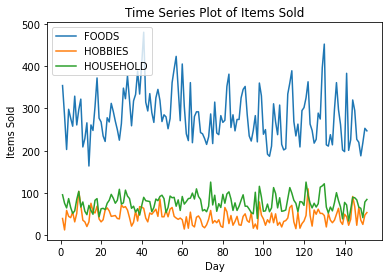

In [21]:
###Finding yearly trends for different product categories
GroupTimeSeriesPlot(by='cat_id')

# 4. Visualisations ?

In [43]:
#Create the dataframe with dropped items when they are not on sale
df = hf.meltM5(sales_df, days = 730, items = 15000)
df = hf.joinDataSets(df, calendar, price_df, dropPriceNA=True)

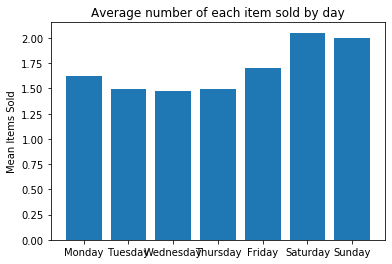

In [71]:
#Mean number of sales per item by day
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
days = df[['sold','weekday']].groupby(['weekday']).mean().reindex(cats) 
plt.bar(days.index, days['sold'])
plt.ylabel('Mean Items Sold')
plt.title('Average number of each item sold by day')
plt.show()

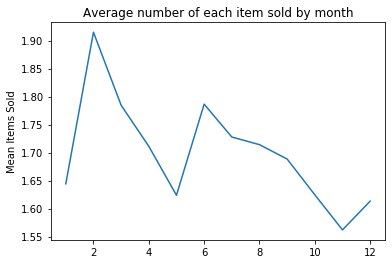

In [125]:
#Mean number of sales per item by month
months = df[['sold','month']].groupby(['month']).mean()
plt.plot(months.index, months['sold'])
plt.ylabel('Mean Items Sold')
plt.title('Average number of each item sold by month')
plt.show()

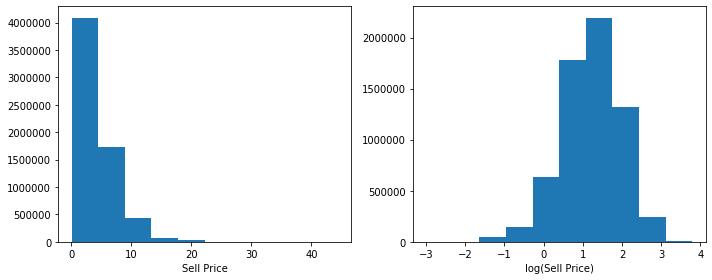

In [81]:
#Histogram of item sell prices
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
ax[0].hist(df['sell_price'])
ax[1].hist(np.log(df['sell_price']))
ax[0].set_xlabel('Sell Price')
ax[1].set_xlabel('log(Sell Price)')
plt.tight_layout()
plt.show()

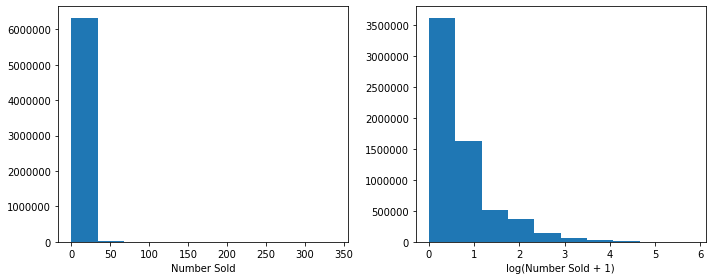

In [86]:
#Histogram of number of items sold
#Had to plus 1 because several values are zero
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
ax[0].hist(df['sold'])
ax[1].hist(np.log(1 + df['sold']))
ax[0].set_xlabel('Number Sold')
ax[1].set_xlabel('log(Number Sold + 1)')
plt.tight_layout()
plt.show()

# Analysing Events

In [113]:
df['event_name_1'] = df['event_name_1'].astype(str)
df['event_type_1'] = df['event_type_1'].astype(str)
df['event_name_2'] = df['event_name_2'].astype(str)
df['event_type_2'] = df['event_type_2'].astype(str)

In [112]:
np.unique(df['event_name_1'])

array(['Chanukah End', 'Christmas', 'Cinco De Mayo', 'ColumbusDay',
       'Easter', 'Eid al-Fitr', 'EidAlAdha', "Father's day", 'Halloween',
       'IndependenceDay', 'LaborDay', 'LentStart', 'LentWeek2',
       'MartinLutherKingDay', 'MemorialDay', "Mother's day",
       'NBAFinalsEnd', 'NBAFinalsStart', 'NewYear', 'OrthodoxChristmas',
       'OrthodoxEaster', 'Pesach End', 'PresidentsDay', 'Purim End',
       'Ramadan starts', 'StPatricksDay', 'SuperBowl', 'Thanksgiving',
       'ValentinesDay', 'VeteransDay', 'nan'], dtype=object)

In [114]:
np.unique(df['event_type_1'])

array(['Cultural', 'National', 'Religious', 'Sporting', 'nan'],
      dtype=object)

In [115]:
np.unique(df['event_name_2'])

array(['Easter', 'nan'], dtype=object)

In [116]:
np.unique(df['event_type_2'])

array(['Cultural', 'nan'], dtype=object)

In [117]:
df['event_name_1'].value_counts()

nan                    5846968
MartinLutherKingDay      19259
OrthodoxChristmas        19125
NewYear                  19027
Christmas                18967
Chanukah End             18947
Thanksgiving             18754
VeteransDay              18709
Halloween                18639
EidAlAdha                18575
ColumbusDay              18360
LaborDay                 18093
Eid al-Fitr              17998
Ramadan starts           17605
IndependenceDay          17315
Father's day             17155
NBAFinalsEnd             17133
NBAFinalsStart           17043
MemorialDay              16994
Mother's day             16795
Cinco De Mayo            16682
Pesach End               16357
OrthodoxEaster           16357
StPatricksDay            15717
Purim End                15671
LentWeek2                15469
LentStart                15266
PresidentsDay            14987
ValentinesDay            14776
SuperBowl                14402
Easter                    9143
Name: event_name_1, dtype: int64

In [118]:
df['event_type_1'].value_counts()

nan          5846968
National      180465
Religious     171370
Cultural      108907
Sporting       48578
Name: event_type_1, dtype: int64

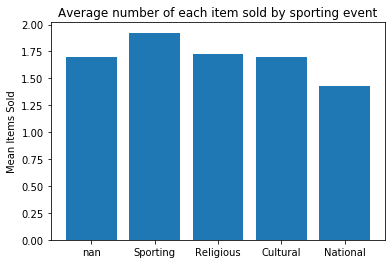

In [124]:
event_cats = ['nan', 'Sporting','Religious','Cultural','National']
events = df[['sold','event_type_1']].groupby(['event_type_1']).mean().reindex(event_cats)
plt.bar(events.index, events['sold'])
plt.ylabel('Mean Items Sold')
plt.title('Average number of each item sold by sporting event')
plt.show()

## Testing rolling window features

In [24]:
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
4,FOODS_3_054_CA_1_evaluation,FOODS_3_054,FOODS_3,FOODS,CA_1,CA,d_1,3,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,1.98
6,FOODS_3_723_TX_1_evaluation,FOODS_3_723,FOODS_3,FOODS,TX_1,TX,d_1,20,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,1.25
9,FOODS_3_732_WI_2_evaluation,FOODS_3_732,FOODS_3,FOODS,WI_2,WI,d_1,1,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,1.98
11,HOBBIES_2_142_WI_3_evaluation,HOBBIES_2_142,HOBBIES_2,HOBBIES,WI_3,WI,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,0.37
16,FOODS_3_449_TX_3_evaluation,FOODS_3_449,FOODS_3,FOODS,TX_3,TX,d_1,4,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,1.98


In [25]:
#7 day average of days immediately prior
df_test = hf.rollingMeanDemandFeature(df, 7, 1)

In [26]:
df_test = df_test[['id','d','sold','rolling_mean_7_1']].copy()
df_test[df_test['id'] == "FOODS_3_723_TX_1_evaluation"]

,id,d,sold,rolling_mean_7_1
6,FOODS_3_723_TX_1_evaluation,d_1,20,NaN
106,FOODS_3_723_TX_1_evaluation,d_2,24,NaN
206,FOODS_3_723_TX_1_evaluation,d_3,21,NaN
306,FOODS_3_723_TX_1_evaluation,d_4,30,NaN
406,FOODS_3_723_TX_1_evaluation,d_5,20,NaN
...,...,...,...,...
29506,FOODS_3_723_TX_1_evaluation,d_296,37,33.285714
29606,FOODS_3_723_TX_1_evaluation,d_297,22,33.714286
29706,FOODS_3_723_TX_1_evaluation,d_298,37,35.285714
29806,FOODS_3_723_TX_1_evaluation,d_299,89,34.714286


In [28]:
#df['sold_lag_'+str(1)] = df.groupby(['id'])['sold'].shift(1)
df_test = hf.lagFeature(df, var='sold', lag=1)

In [29]:
df_test.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'sold', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'rolling_mean_7_1',
       'sold_lag_1'],
      dtype='object')

In [31]:
df_test = df[['id','d','sold','sold_lag_1']].copy()
df_test[df_test['id'] == "FOODS_3_723_TX_1_evaluation"]

,id,d,sold,sold_lag_1
6,FOODS_3_723_TX_1_evaluation,d_1,20,NaN
106,FOODS_3_723_TX_1_evaluation,d_2,24,20.0
206,FOODS_3_723_TX_1_evaluation,d_3,21,24.0
306,FOODS_3_723_TX_1_evaluation,d_4,30,21.0
406,FOODS_3_723_TX_1_evaluation,d_5,20,30.0
...,...,...,...,...
29506,FOODS_3_723_TX_1_evaluation,d_296,37,33.0
29606,FOODS_3_723_TX_1_evaluation,d_297,22,37.0
29706,FOODS_3_723_TX_1_evaluation,d_298,37,22.0
29806,FOODS_3_723_TX_1_evaluation,d_299,89,37.0


In [8]:
test_df = hf.cleanEvents(df)

In [98]:
print(np.unique(calendar.event_name_1.astype(str)))
print(np.unique(calendar.event_name_2.astype(str)))

print(np.unique(calendar.event_type_1.astype(str)))
print(np.unique(calendar.event_type_2.astype(str)))

['Chanukah End' 'Christmas' 'Cinco De Mayo' 'ColumbusDay' 'Easter'
 'Eid al-Fitr' 'EidAlAdha' "Father's day" 'Halloween' 'IndependenceDay'
 'LaborDay' 'LentStart' 'LentWeek2' 'MartinLutherKingDay' 'MemorialDay'
 "Mother's day" 'NBAFinalsEnd' 'NBAFinalsStart' 'NewYear'
 'OrthodoxChristmas' 'OrthodoxEaster' 'Pesach End' 'PresidentsDay'
 'Purim End' 'Ramadan starts' 'StPatricksDay' 'SuperBowl' 'Thanksgiving'
 'ValentinesDay' 'VeteransDay' 'nan']
['Cinco De Mayo' 'Easter' "Father's day" 'OrthodoxEaster' 'nan']
['Cultural' 'National' 'Religious' 'Sporting' 'nan']
['Cultural' 'Religious' 'nan']


In [ ]:
df['event_name_1'] == "Christmas"